# What are the properties of $\sum_{\omega\in \Lambda \subset \mathcal{D}} c_\omega \omega$ as $|\Lambda| \to \infty$?
In particular, do we see any sensible behaviour of $\sum_{\omega\in\Lambda} | c_\omega |^2$?

In [47]:
import numpy as np
import scipy as sp
import math
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import omp

importlib.reload(omp)

%matplotlib inline

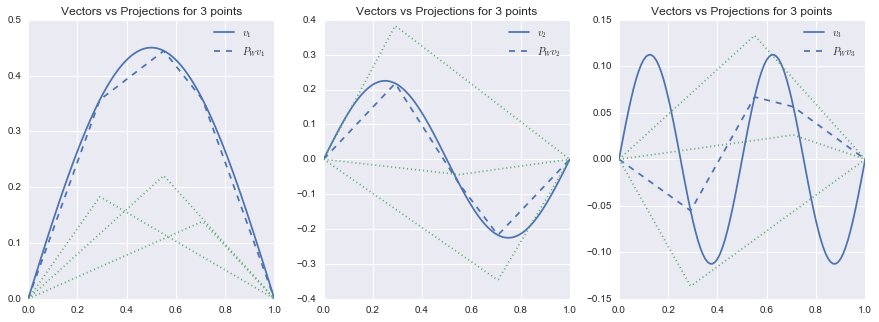

In [60]:
N = 400
xs = np.arange(0,1.01,0.01)

# We make a basis (not dictionary - so we can project... as in our case we *do* 
# have linear independence) of random points
np.random.seed(3)
W = omp.make_random_delta_basis(N)

# The vectors we want to approximate:
vs = [omp.Vector([1.0], [1.0], ['H1sin']), \
      omp.Vector([2.0], [1.0], ['H1sin']), \
      omp.Vector([4.0], [1.0], ['H1sin'])]

sns.set_palette("deep")
cp = sns.color_palette()

fig = plt.figure(figsize=(15, 5))

for i, v in enumerate(vs):
    ax = fig.add_subplot(1, 3, i+1, title=r'Vectors vs Projections for 3 points')

    ax.plot(xs, v.evaluate(xs), label=r'$v_{{{0}}}$'.format(i+1), color=cp[0])

    vW = W.subspace(slice(0,3)).project(v)
    ax.plot(xs, vW.evaluate(xs), '--', label=r'$P_W v_{{{0}}}$'.format(i+1), color=cp[0])
    
    for p, c in zip(vW.params[0], vW.coeffs[0]):
        ax.plot(xs, c * omp.del_evaluate(xs, np.array([p])), ':', color=cp[1])
    ax.legend()

plt.show()


## Now about that convergence...

We have that $\| P_{W_m} v \| = \left \| \sum_{k=1}^m c_k \omega_k \right \| \to \| v \|$ as $m\to \infty$ (and in this case $\| v \| = 1$). But just how bad is the bound
$$ 
\left \| \sum_{k=1}^m c_k \omega_k \right \| \le \sum_{k=1}^m | c_k | \| \omega_k \| = \sum_{k=1}^m | c_k | 
$$
And the bound 
$$ 
\left \| \sum_{k=1}^m c_k \omega_k \right \| \le \sum_{k=1}^m | c_k | \| \omega_k \| = \sqrt{m} \left(\sum_{k=1}^m c_k ^2 \right)^{1/2} \, ?
$$
Because we use these bounds in the proof of the OMP convergence. Well, lets find out.

Also to check is the bound:
$$
\| P_{W_m} v \|_V = \left\langle \sum_k c_k \omega_k, \sum_j c_j \omega_j \right\rangle_V = \sum_{j,k} c_j c_k \langle \omega_j, \omega_k \rangle_V \le \| \mathbf{G} \|_2 \| \mathbf{c} \|_2^2
$$
where $\mathbf{G}$ is the Gramian of $W_m$, and the norm is 2-norm or spectral norm for matrices. We do this for a random $W_m$ for $m$ from $1$ to $200$.

In [61]:
cw_L1 = np.zeros((len(vs), N))
cw_L2 = np.zeros((len(vs), N))
proj_norm = np.zeros((len(vs), N))
proj_err = np.zeros((len(vs), N))

gram_bnd = np.zeros((len(vs), N))
gram_norm = np.zeros((len(vs), N))

gram_mult = np.zeros((len(vs), N))

W.make_grammian()
for i, v in enumerate(vs):
    for m in range(1,N+1):
        Wm = W.subspace(slice(0,m))
        
        # cW is essentially the coefficients of the vectors that go in to the 
        # projections, but the projections are ordered, so preserve the ordering for some 
        # gramian calcs later, we obtain it here
        vW, cW = Wm.project(v, return_coeffs=True)
        
        proj_err[i, m-1] = (v - vW).norm()
        proj_norm[i, m-1] = vW.norm()
        cw_L1[i, m-1] =  np.linalg.norm(vW.coeffs[0], ord=1)# * (math.pi * v.params[0][0] / math.sqrt(2.0)) * (math.pi * v.params[0][0] / math.sqrt(2.0))
        cw_L2[i, m-1] =  np.linalg.norm(vW.coeffs[0], ord=2)# * (math.pi * v.params[0][0] / math.sqrt(2.0))
        gram_bnd[i, m-1] =  np.linalg.norm(vW.coeffs[0], ord=2) * math.sqrt(np.linalg.norm(W.subspace(slice(0,m)).G, ord=2))
        gram_norm[i, m-1] =  math.sqrt(np.linalg.norm(W.subspace(slice(0,m)).G, ord=2))
        
        gram_mult[i, m-1] = math.sqrt(np.dot(cW, W.subspace(slice(0,m)).G @ cW))

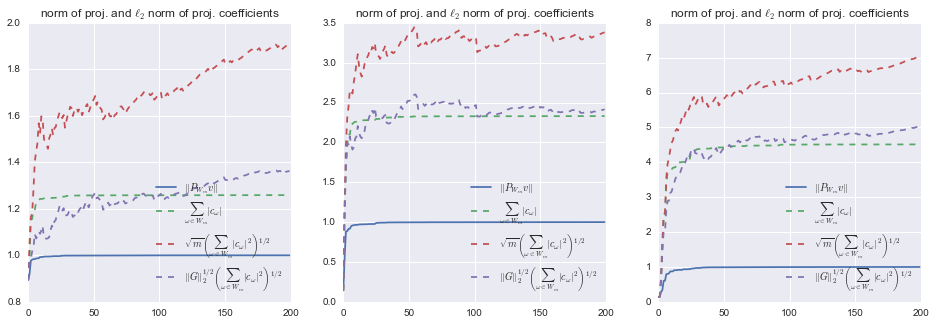

In [59]:
%matplotlib inline
fig = plt.figure(figsize=(16, 5))

for i, v in enumerate(vs):
    ax = fig.add_subplot(1, 3, i+1, title=r'norm of proj. and $\ell_2$ norm of proj. coefficients')

    ax.plot(range(N), proj_norm[i,:], label=r'$\| P_{W_m} v \|$',  color=cp[0])
    ax.plot(range(N), cw_L1[i,:], '--', label=r'$\sum_{\omega\in W_m} | c_\omega | $', color=cp[1])
    ax.plot(range(N), np.sqrt(range(1,N+1)) * cw_L2[i,:], '--', label=r'$\sqrt{m} \left(\sum_{\omega\in W_m} | c_\omega |^2 \right)^{1/2}$', color=cp[2])
    ax.plot(range(N), gram_bnd[i,:], '--', label=r'$\| G \|_2^{1/2} \left(\sum_{\omega\in W_m} | c_\omega |^2 \right)^{1/2}$', color=cp[3])
    #ax.plot(range(N), gram_mult[i,:], '--', label=r'$c^T G c$', color=cp[4])

    ax.legend(loc=4)

plt.show()

<IPython.core.display.Javascript object>


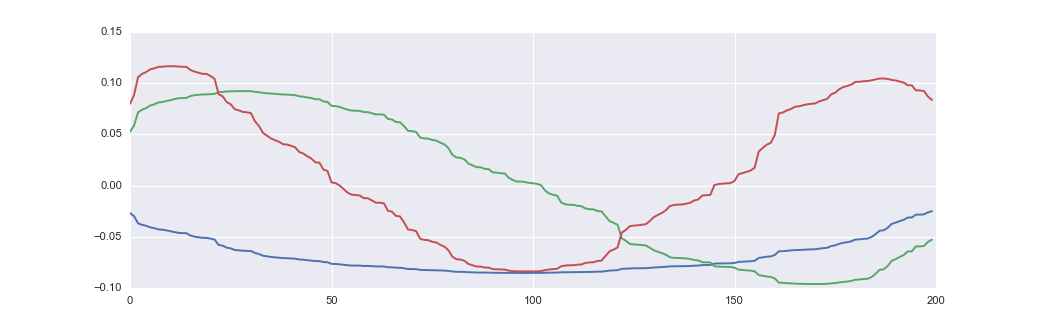

In [28]:
sorted_p = np.sort([w.params[0][0] for w in W.vecs])

Ws = omp.Basis([omp.Vector([p], [1.0], ['H1delta']) for p in sorted_p])

Ws.make_grammian()

lam, V = np.linalg.eig(Ws.G)

%matplotlib notebook
fig = plt.figure(figsize=(13, 4))
plt.plot(V[:,0])
plt.plot(V[:,1])
plt.plot(V[:,2])
plt.show()

